In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_json('../../Dataset/news_dataset.json')
df.head()

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [4]:
df.category.value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

Undersampling

In [5]:
min_samples = 1381 # Science minority class

df_business = df[df.category == 'BUSINESS'].sample(min_samples,random_state=2025)
df_sports = df[df.category == 'SPORTS'].sample(min_samples,random_state=2025)
df_crime = df[df.category == 'CRIME'].sample(min_samples,random_state=2025)
df_science = df[df.category == 'SCIENCE'].sample(min_samples,random_state=2025)


In [6]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()

category
BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: count, dtype: int64

In [7]:
target = {'BUSINESS':0,'SPORTS':1,'CRIME':2,'SCIENCE':3}
df_balanced['category_num'] = df_balanced['category'].map(target)
df_balanced.head()

,text,category,category_num
9085,Different Is the New Normal: Perspectives From...,BUSINESS,0
5758,3 Reasons Obama's Oil Tax Would Be Good For Am...,BUSINESS,0
1607,Seattle Passes Controversial New Tax On City's...,BUSINESS,0
9560,Ailes' Downfall Is A Testament To The Rising P...,BUSINESS,0
12140,Is Under Armour Copying Nike's Playbook? While...,BUSINESS,0


Build a model with original text (no pre processing)


In [8]:
X_train,X_test,y_train,y_test = train_test_split(
    df_balanced.text,
    df_balanced.category_num,
    test_size=0.2,
    random_state=2025,
    stratify=df_balanced.category_num
)

In [9]:
print(X_train.shape)
X_train.head()

(4419,)


9917     What The AT&T-Time Warner Merger Will Actually...
6152     Venus Fights To Bitter End, But Loses Quarter-...
2778     Will It Matter? The Pope, the Environment and ...
11120        WATCH: Tebow's Hilarious Spurrier Impression 
7806     The Secret To Being Happy And Loving Your Job ...
Name: text, dtype: object

In [10]:
y_train.value_counts()

category_num
0    1105
1    1105
3    1105
2    1104
Name: count, dtype: int64

In [11]:
y_test.value_counts()

category_num
2    277
3    276
1    276
0    276
Name: count, dtype: int64

Attempt 1 : Use 1-gram which is nothing but a Bag Of Words (BOW) model

In [12]:
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1,1))),
    ('Multi NB',MultinomialNB())
])

clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer_bow', CountVectorizer()),
                ('Multi NB', MultinomialNB())])

In [13]:
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       276
           1       0.89      0.85      0.87       276
           2       0.89      0.92      0.91       277
           3       0.89      0.83      0.86       276

    accuracy                           0.87      1105
   macro avg       0.88      0.87      0.87      1105
weighted avg       0.88      0.87      0.87      1105



In [14]:
# Compare y_test and y_pred
y_test[:5]

7198     3
1872     1
10247    1
11208    1
6059     1
Name: category_num, dtype: int64

In [15]:
y_pred[:5]

array([0, 1, 1, 1, 1])

Attempt 2 : Use 1-gram and bigrams

In [16]:
clf = Pipeline([
    ('vectorizer_1_2_gram',CountVectorizer(ngram_range=(1,2))),
    ('Multi NB',MultinomialNB())
])

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       276
           1       0.93      0.82      0.87       276
           2       0.91      0.90      0.90       277
           3       0.91      0.82      0.86       276

    accuracy                           0.87      1105
   macro avg       0.88      0.87      0.87      1105
weighted avg       0.88      0.87      0.87      1105



Attempt 3 : Use 1-gram to trigrams

In [17]:
clf = Pipeline([
    ('vectorizer_1_2_gram',CountVectorizer(ngram_range=(1,3))),
    ('Multi NB',MultinomialNB())
])

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.94      0.83       276
           1       0.93      0.82      0.87       276
           2       0.91      0.89      0.90       277
           3       0.90      0.79      0.84       276

    accuracy                           0.86      1105
   macro avg       0.87      0.86      0.86      1105
weighted avg       0.87      0.86      0.86      1105



Use text pre-processing to remove stop words, punctuations and apply lemmatization

In [18]:
import spacy

nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    filterd_token = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filterd_token.append(token.lemma_)
    return " ".join(filterd_token)

In [19]:
df_balanced['preprocessed_txt'] = df_balanced['text'].apply(preprocess)

In [20]:
df_balanced.head()

,text,category,category_num,preprocessed_txt
9085,Different Is the New Normal: Perspectives From...,BUSINESS,0,Different New Normal perspective China Travel ...
5758,3 Reasons Obama's Oil Tax Would Be Good For Am...,BUSINESS,0,3 Reasons Obama Oil Tax good America push gas ...
1607,Seattle Passes Controversial New Tax On City's...,BUSINESS,0,Seattle pass Controversial New Tax City big co...
9560,Ailes' Downfall Is A Testament To The Rising P...,BUSINESS,0,Ailes downfall testament rise power Women mess
12140,Is Under Armour Copying Nike's Playbook? While...,BUSINESS,0,Armour Copying Nike Playbook sport shoe appare...


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_txt, 
    df_balanced.category_num, 
    test_size=0.2,
    random_state=2025,
    stratify=df_balanced.category_num
)

In [22]:

print(X_train.shape)
X_train.head()

(4419,)


9917     AT&T Time Warner Merger actually service analy...
6152     Venus fight bitter end lose Quarter Final Batt...
2778     matter Pope Environment Tips Pope action clima...
11120            WATCH Tebow Hilarious Spurrier impression
7806     secret happy love Job way happiness happiness way
Name: preprocessed_txt, dtype: object

In [23]:
y_train.value_counts()

category_num
0    1105
1    1105
3    1105
2    1104
Name: count, dtype: int64

In [24]:
y_test.value_counts()

category_num
2    277
3    276
1    276
0    276
Name: count, dtype: int64

In [25]:
clf = Pipeline([
    ('vectorizer_1_2_gram',CountVectorizer(ngram_range=(1,2))),
    ('Multi NB',MultinomialNB())
])

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       276
           1       0.92      0.91      0.91       276
           2       0.86      0.95      0.90       277
           3       0.93      0.83      0.88       276

    accuracy                           0.89      1105
   macro avg       0.89      0.89      0.89      1105
weighted avg       0.89      0.89      0.89      1105



In [27]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[246,  10,   8,  12],
       [  3, 250,  19,   4],
       [  9,   4, 262,   2],
       [ 24,   9,  14, 229]])

Text(95.72222222222221, 0.5, 'Truth')

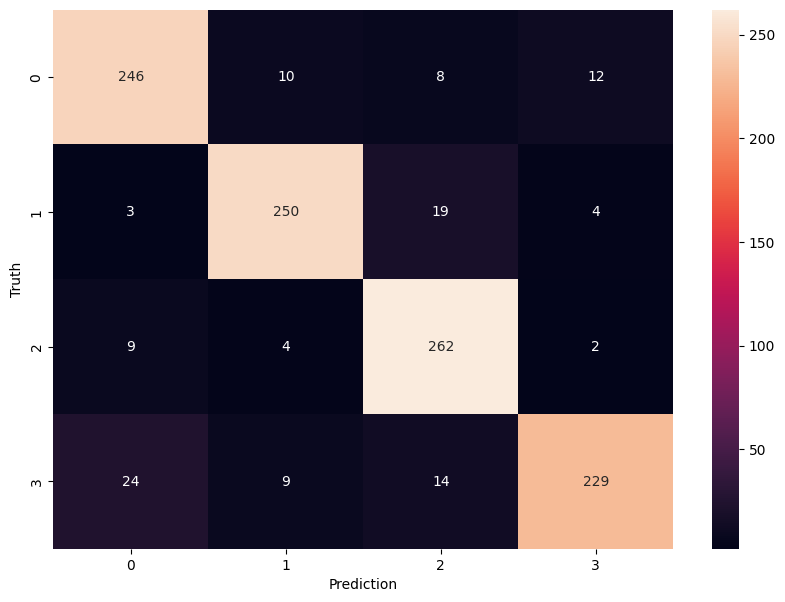

In [29]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')